In [1]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [2]:
# Kernel Adapters

def spectral_mixture_kernel(train_x, train_y, n_mixtures):
    covar_module = gpytorch.kernels.SpectralMixtureKernel(
        num_mixtures=n_mixtures)
    covar_module.initialize_from_data(train_x, train_y)
    return covar_module
    

def scale_kernel():
    return gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

In [3]:
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GaussianProcess, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = spectral_mixture_kernel(train_x, train_y, n_mixtures=4)
        #self.covar_module = scale_kernel()
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
class GPSoundGenerator:
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
        self.train_x = np.array([])
        self.train_y = np.array([])
        
    def update_train_data(self, train_x, train_y):
        self.train_x = torch.from_numpy(np.array(train_x, dtype=np.float32).reshape(-1, 1))
                                        
        self.train_y = torch.from_numpy(np.array(train_y, dtype=np.float32))
        self.model = GaussianProcess(
            self.train_x, self.train_y, self.likelihood)

    def fit(self, train_iter=50, lr=0.1, verbose=0, with_evaluation=False):
        
        self.model.train()
        self.likelihood.train()
        
        # Optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr)
        # Loss function
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(
            self.likelihood, self.model)

        for i in range(train_iter):

            if with_evaluation and i % 10 == 0:
                mean_and_confidence = self.mean_and_confidence_region((0, 5))
                sample = self.sample_from_posterior((0, 5))
                self.plot_data(False, mean_and_confidence)

                self.model.train()
                self.likelihood.train()
            
            optimizer.zero_grad()
            output = self.model(self.train_x)
            loss = -mll(output, self.train_y)
            loss.backward()
            
            if verbose != 0:
                print(f'Iter{(i+1)}/{train_iter} - Loss: {loss.item()}')

            optimizer.step()

    def sample_from_posterior(self, test_x_range):
        self.model.eval()
        self.likelihood.eval()
        
        start, end = test_x_range
        x_range = (end - start)
        test_x = torch.linspace(start, end, self.sample_rate * x_range)

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            f_preds = self.likelihood(self.model(test_x))
            f_samples = f_preds.sample().numpy()
            
        return f_samples

    def mean_and_confidence_region(self, test_x_range):
        self.model.eval()
        self.likelihood.eval()

        start, end = test_x_range
        x_range = (end - start)
        test_x = torch.linspace(start, end, self.sample_rate * x_range)

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = self.model(test_x)
            mean = observed_pred.mean.numpy()
            lower, upper = observed_pred.confidence_region()
            
        return mean, (lower, upper)

    def plot_data(self, is_sample, data):
        test_x = torch.linspace(0, 5, self.sample_rate * 5)

        f, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.plot(self.train_x, self.train_y, 'k*')
        ax.set_ylim([-5, 7.5])

        if is_sample:
            ax.plot(test_x.numpy(), data)
            ax.legend(['Data', 'Sample from posterior'])
        else:
            mean, (lower, upper) = data
            ax.plot(test_x.numpy(), mean, 'b')
            ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
            ax.legend(['Observed Data', 'Mean', 'Confidence'])
        

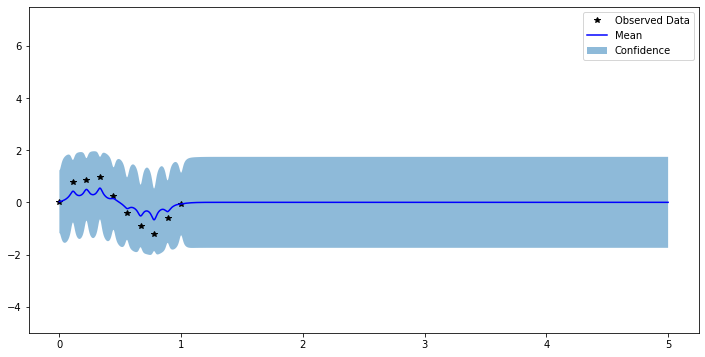

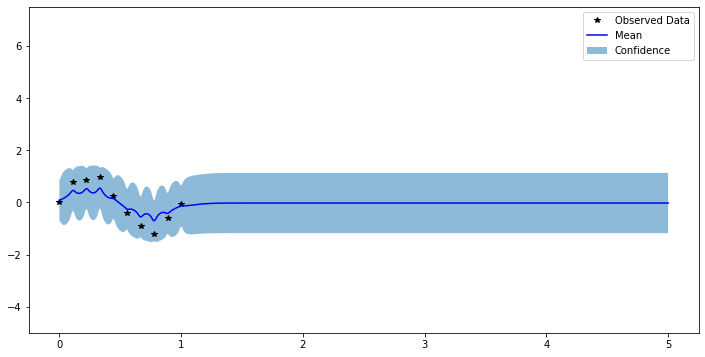

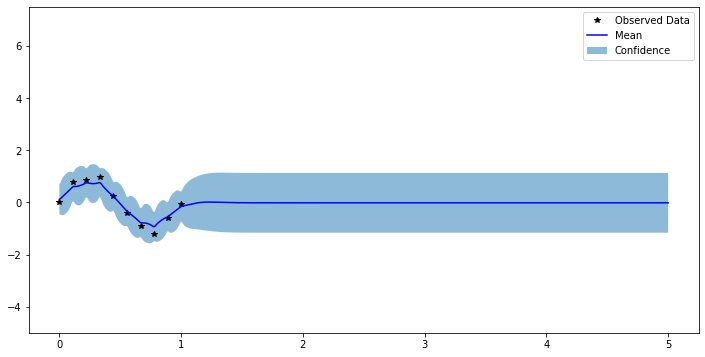

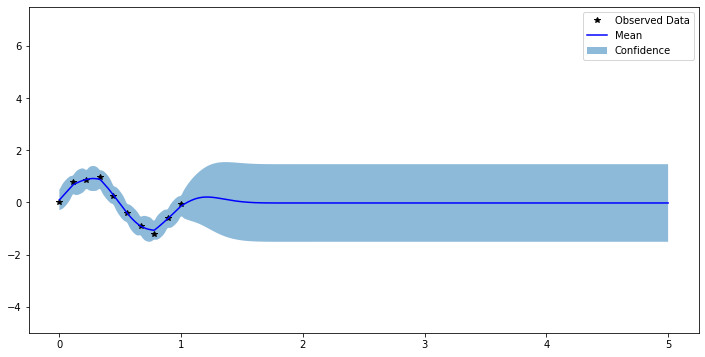

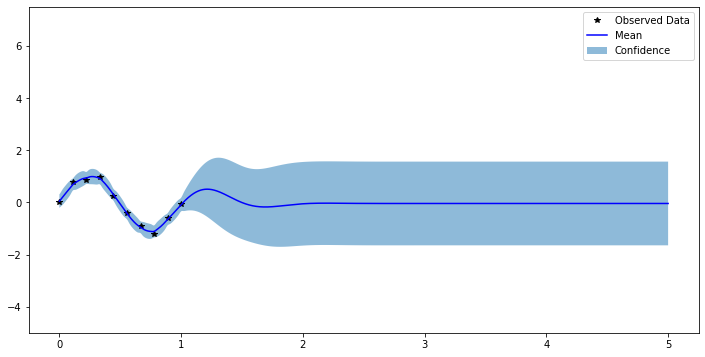

In [12]:
# train_x = [1, 2, 3, 4, 5]
# train_y = [3, 4, 1, 3, 2]
import math

train_x = torch.linspace(0, 1, 10)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

sound_generator = GPSoundGenerator(sample_rate=1000)
sound_generator.update_train_data(train_x, train_y)
samples_before_training = sound_generator.sample_from_posterior((0, 5))
mean_b, (lower_b, upper_b) = sound_generator.mean_and_confidence_region((0, 5))
sound_generator.fit(with_evaluation=True)
samples_after_training = sound_generator.sample_from_posterior((0, 5))
mean_a, (lower_a, upper_a) = sound_generator.mean_and_confidence_region((0, 5))

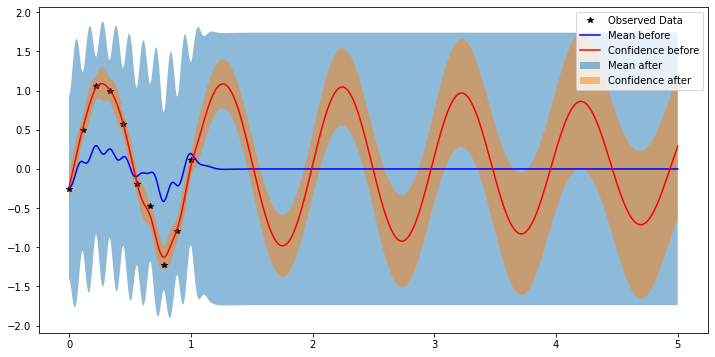

In [98]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(train_x, train_y, 'k*')
ax.plot(test_x.numpy(), mean_b, 'b')
ax.fill_between(test_x.numpy(), lower_b, upper_b, alpha=0.5)
ax.plot(test_x.numpy(), mean_a, 'r')
ax.fill_between(test_x.numpy(), lower_a, upper_a, alpha=0.5)
ax.legend(['Observed Data', 'Mean before', 'Confidence before', 
           'Mean after', 'Confidence after'])

In [18]:
model = sound_generator.model
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name} value = {param}')

Parameter name: likelihood.noise_covar.raw_noise value = Parameter containing:
tensor([-4.6905], requires_grad=True)
Parameter name: mean_module.constant value = Parameter containing:
tensor([-0.0320], requires_grad=True)
Parameter name: covar_module.raw_mixture_weights value = Parameter containing:
tensor([-0.9919, -5.8897, -6.0132, -5.9634], requires_grad=True)
Parameter name: covar_module.raw_mixture_means value = Parameter containing:
tensor([[[ 0.5497]],

        [[-4.9260]],

        [[ 2.8830]],

        [[ 0.6742]]], requires_grad=True)
Parameter name: covar_module.raw_mixture_scales value = Parameter containing:
tensor([[[-2.3194]],

        [[ 0.1694]],

        [[11.2802]],

        [[ 3.8093]]], requires_grad=True)


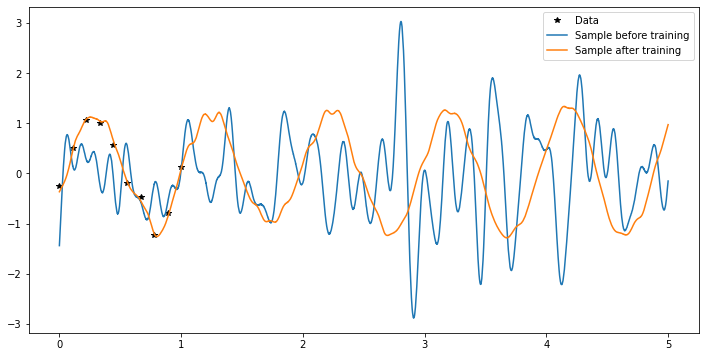

In [99]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(train_x, train_y, 'k*')

ax.plot(test_x.numpy(), samples_before_training)
ax.plot(test_x.numpy(), samples_after_training)
ax.legend(['Data', 'Sample before training', 'Sample after training'])